# Inequality in New Zealand and its Impacts on Socioeconomics Factors

#### Student name: Eduardo Bernardoni Chaves
#### Student ID: 22004916

## 1. Introduction

There are many ways that generalised inequality can impact our lives. Despite the fact that inequality is usually associated with income differences, there are many areas in which inequality has a significant effect.<br>
A wide variety of factors are studied in inequality research, including health and education, and the impact of inequality in economic growth.

This report will initially evaluate the timeline of inequality in New Zealand accross multiple variables, then it will compare New Zealand with other countries on their GINI coefficient.
Finally, the correlation between inequality coefficients and socioeconomic variables accross other areas of society are evaluated to determine the potential impact of inequality accross other sectors.

The objective is to understand the inequality scenario in New Zealand and find potential valid correlations so that socioeconomic factors in various fields can be improved with the reduction of inequality in the country.

### 1.1 Datasets Used

* Shared Prosperity Assignment Dataset
* Shared Prosperity Assignment Dataset - Data Documentation
* OECD Economic Inequality GINI index

### 1.2 Research Questions

- What is the trend of inequality indexes in New Zealand over the analysed period?
- How is NZ inequality variance over the analysed period is compared to other countries?
- How was the different levels of the GINI coefficient distributed overtime (GINI density)?
- Is poverty and inequality the same in macroeconomic measures? (developed countries are equal while low-income countries are unequal)
- In New Zealand, inequality and poverty move in the same direction overtime?
- What is the correlation between Inequality vs Health and Education values in New Zealand?

### 1.3 Preparation, Import Packages and Files

In [1]:
#Importing all necessary packages

import math
import pandas as pd
import regex as re
import numpy as np
import collections as cl
import seaborn as sns
import scipy
import scipy.stats as stats
from scipy.stats import linregress

import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore")

##### Starting the report by importing the necessary datasets and manipulating it accordingly

In [2]:
#Define path file of dataset used and assign dataframe

data_file = r"C:\Users\eduar\Documents\Studies\Master of Analytics\00Assignments\02. Intro to Analytics - Assignemnt 1 (10.04) - in progress\Dataset\shared_prosperity_assignment_dataset_mangled.csv"
df = pd.read_csv(data_file)


# Define path file of international GINI coefficient used in this analysis (Ref 1)

data_gini=r"C:\Users\eduar\Documents\Studies\Master of Analytics\00Assignments\02. Intro to Analytics - Assignemnt 1 (10.04) - in progress\Dataset\economic-inequality-gini-index.csv"
dfglobal = pd.read_csv(data_gini)

In [3]:
#Import Documentation file, merging all worksheets into one and adding a new column 'category' based on each sheet name.

workbook = pd.ExcelFile(r"C:\Users\eduar\Documents\Studies\Master of Analytics\00Assignments\02. Intro to Analytics - Assignemnt 1 (10.04) - in progress\Dataset\Data documentation.xlsx")
sheets = workbook.sheet_names

dfdoc=pd.concat([pd.read_excel(workbook, sheet_name=s)
                 .assign(Category=s) for s in sheets])

#Droping rows that are not linked to any 'Column name in dataset' to simplify dfdoc

dfdoc.dropna(subset=['Column name in dataset'], inplace=True)
dfdoc=dfdoc[['Column name in dataset','Description','Further information','Category']]

##  2. Data Cleaning

### 2.1 Cleaning annomalities in data

#### After the data quality analysis of the dataset, unusual characteristics were identified in some variables, that were treated accordingly as below.

In [4]:
#Delete characters after '\' to clean data
for name,values in df.iloc[0, :].iteritems():
    df[name] = df[name].astype(str).str.split('\\').str[0]
    
       
#Replace all commas with dots to prepare for future float conversion
for i in range(0,len(df)):
    for name,values in df.iloc[[0, i]].iteritems():
        df[name][i]=re.sub(r',','.',str(df[name][i]))

        
#Delete characters present in numeric fields
for i in range(0,len(df)):
    for name,values in df.iloc[[0, i]].iteritems():
        df[name][i]=re.sub(r'[A-Z]','',str(df[name][i])) 

        
#Sort df by year and as there is only one record per year, converting datetime to just year to simplify dataset. Also useful to 'fillna' more accurately later

df['year']=pd.DatetimeIndex(df['year']). year


#Replace non-standard strings for NaN and replace ',' for '.' to assign float
df = df.replace(['???','-','NAN','nan'],np.nan,regex=False)


#Convert all to float
for name,values in df.iloc[0, :].iteritems():
    df[name]= df[name].apply(pd.to_numeric)

    
#Convert 'Year' to int
df['year']=df['year'].astype(int)

#### Initial data cleaning completed and below a list of potential data errors based on outliers are identified

In [5]:
#Look for potential outliers in the dataset. The dataframe dfout will be used as a guide to look for potentially incorrect data input

outlier_list=[]

for i in range(0,len(df)):
    for name,values in df.iloc[[0, i]].iteritems():
        std1=np.std(df[name])
        mean1=np.mean(df[name])
        if df[name][i]<mean1-(2*std1):
            outlier= (name,i,round(df[name][i],2),round(mean1,2),round(std1,2))
            outlier_list.append(outlier)
        elif df[name][i]>mean1+(2*std1):
            outlier= (name,i,round(df[name][i],2),round(mean1,2),round(std1,2))
            outlier_list.append(outlier)
    else:
        pass

dfout=pd.DataFrame(outlier_list,columns=['Variable','Index','Value','Mean','Std Dev'])

dfout.to_csv(r"C:\Users\eduar\Documents\Studies\Master of Analytics\00Assignments\02. Intro to Analytics - Assignemnt 1 (10.04) - in progress\Dataset\outlier.csv")

dfout.head(5)

,Variable,Index,Value,Mean,Std Dev
0,LIH_B50_CV_AHC,0,22.00,13.45,4.19
1,child_poverty_ahc_perc_HH_B50_CV,0,34.00,19.60,6.92
2,long_term_unemployment_rate,0,32.94,16.05,7.65
3,problem_gambling_intervention_prevelance_percent,3,0.10,0.01,0.03
4,UN_middle_class_def_inc_share,5,53.60,21.46,6.41


### After evaluating the outliers identified, the 11 records below were considered for review:

#### Treat outliers
* UN_middle_class_def_inc_share | Index5, Value 53.6 | Assumed value for 1999 needs to be switched with OECD_middle_class... variable
* OECD_middle_class_def_inc_share | Index5, Value 22.9 | Assumed value for 1999 needs to be switched with UN_middle_class... variable
* gender_pay_gap | Index19, Value 0 | Delete. Not possible a 0 gender pay gap (1997)
* GINI-BHC | Index20, Value 101.5 | Delete, out of GINI Range.
* unmet_GP_care_due_to_cost_adult | Index23, Value 111.3 | Delete, outlier.
* rate_of_personal_insolvencies | Index27, Value 11.92 | Divide by 10 as it looks like was not converted to percentages.
* Q5:Q1 | Index33, Value -1.5 | Delete, negative ratio not possible.
* loan_delinquency_percent | Index15, Value 24.08 | Delete. Potentially correct as it's 2009 (financial crisis), but can't confirm exactly.

#### Keep
* LIH_B60_contemp_median_AHC | Index9, Value 7 | Keep, outlier but probable correct input as similar to closer years
* long_term_unemployment_rate | Index21,  Value 32.37 | Keep, in line with unemployment rate of the closer years
* long_term_unemployment_rate | Index25, Value 33.76 | Keep, in line with unemployment rate of the closer years

In [6]:
#Treat outliers identified above

#Switch UN vs OECD data for index 5
#temporary assign to variable
UN=df['UN_middle_class_def_inc_share'][5]
OECD=df['OECD_middle_class_def_inc_share'][5]

#Invert order of values
df['UN_middle_class_def_inc_share'][5]=OECD
df['OECD_middle_class_def_inc_share'][5]=UN

#Delete gender pay gap outlier
df['gender_pay_gap'] = df['gender_pay_gap'].replace([0.0],np.nan,regex=False)

#Delete GINI outlier
df['GINI-BHC'] = df['GINI-BHC'].replace([101.5],np.nan,regex=False)

#Delete Unmet GP Care outlier
df['unmet_GP_care_due_to_cost_adult'] = df['unmet_GP_care_due_to_cost_adult'].replace([111.3],np.nan,regex=False)

# Rate of Personal Insolvencies outlier - Divide by 100 to convert to percentage
df['rate_of_personal_insolvencies'] = df['rate_of_personal_insolvencies']/100

#Delete Q5:Q1 outlier
df['Q5:Q1'] = df['Q5:Q1'].replace([-1.5],np.nan,regex=False)

#Delete Loan Deliquency % outlier
df['loan_delinquency_percent'] = df['loan_delinquency_percent'].replace([24.08],np.nan,regex=False)

In [7]:
#Opted for a 'forward fill' followed by a 'before fill', to complete some of the NaN data. Using 'mean' was creating big discrepancies in data.

df=df.sort_values('year')

df = df.fillna(method="ffill",limit=1)
df = df.fillna(method="bfill",limit=1)

### 2.2 Visualise boxplot of variables of interest

#### After identifying different inequality indexes, the report will evaluate outliers on these variables before starting analysis.<br>The main inequality measurements that are used in this report are: 

* GINI-BHC
* Ratio of 1st Decile vs 10th Decile Incomes
* University Fees/Mean Salary Ratio
* Top 10% Wealth Share
* Regional GDP Variance
* Gender Pay Gap

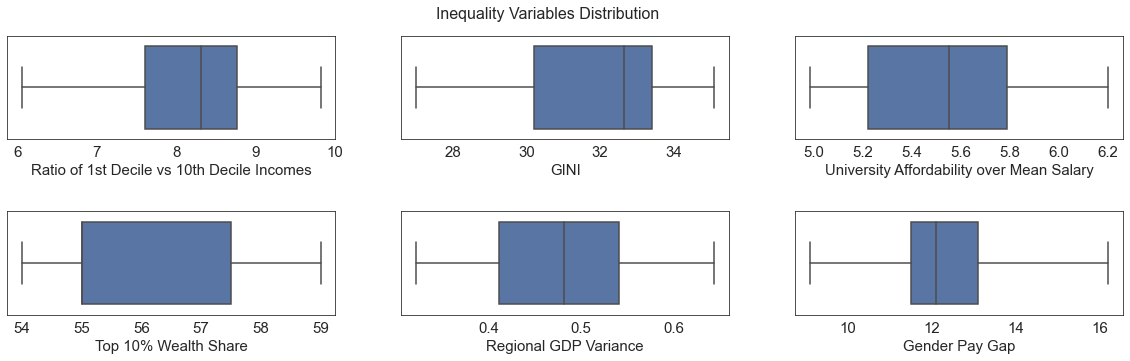

In [8]:
#Looking for Outliers running boxplots. 
#It was assigned a 2x standard deviation limit to point outliers in the boxplot
colors = ["#336699", "#993366","#ABABAB","#B73A1E"]

sns.set_palette(sns.color_palette(colors))
sns.set({'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 20, 'axes.titlesize': 30})
sns.set_style("white")
plt.rcParams['figure.figsize'] = [20,5]

fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.2)

plt.subplots_adjust(top=0.9)
plt.suptitle('Inequality Variables Distribution', fontsize = 16)

ax = fig.add_subplot(2, 3, 1)
sns.boxplot(x=df['D10:D1'], whis=2)
plt.xlabel("Ratio of 1st Decile vs 10th Decile Incomes")

ax = fig.add_subplot(2, 3, 2)
sns.boxplot(x=df['GINI-BHC'], whis=2)
plt.xlabel("GINI")

ax = fig.add_subplot(2, 3, 3)
sns.boxplot(x=df['university_affordability_ratio_to_mean_salary'], whis=2)
plt.xlabel("University Affordability over Mean Salary")

ax = fig.add_subplot(2, 3, 4)
sns.ylabel='Test'
sns.boxplot(x=df['top_10_perc_wealth_share'],whis=2)
plt.xlabel("Top 10% Wealth Share")

ax = fig.add_subplot(2, 3, 5)
sns.boxplot(x=df['regional_gdp_proportional_variation'],whis=2)
plt.xlabel("Regional GDP Variance")

ax = fig.add_subplot(2, 3, 6)
sns.boxplot(x=df['gender_pay_gap'],whis=2)
plt.xlabel("Gender Pay Gap")

plt.show()

##### The boxplot above shows an outlier on GINI-BHC and Gender Pay Gap variable that need to be checked.
#### For each variable, the standard deviation and mean were calculated. <br> The identified records were deleted from the dataset to maintain high data quality standards.


In [9]:
#Identify Outliers that are potentially incorrectly inputed (more than 2 standard deviations variance)

std1=np.std(df['GINI-BHC'])
mean1=np.mean(df['GINI-BHC'])

for i in range(0,37):
    if df['GINI-BHC'][i]<mean1-(2*std1):
        print("Outlier identified: >2 standard deviation variance GINI: ",df['GINI-BHC'][i])
    elif df['GINI-BHC'][i]>mean1+(2*std1):
        print("Outlier identified: >2 standard deviation variance GINI: ",df['GINI-BHC'][i])
    else:
        pass
              
std2=np.std(df['gender_pay_gap'])
mean2=np.mean(df['gender_pay_gap'])

for i in range(0,37):
    if df['gender_pay_gap'][i]<mean2-(2*std2):
        print("Outlier identified: >2 standard deviation variance Gender Pay Gap: ",df['gender_pay_gap'][i])
    elif df['gender_pay_gap'][i]>mean2+(2*std2):
        print("Outlier identified: >2 standard deviation variance Gender Pay Gap: ",df['gender_pay_gap'][i])
    else:
        pass              

Outlier identified: >2 standard deviation variance Gender Pay Gap:  16.2
Outlier identified: >2 standard deviation variance Gender Pay Gap:  16.2


##### After analysing the outliers above, it was concluded that all are reasonable and do not need to be treated as annomalities in the dataset.

## 3. Data Visualisation

#### Before showing the data of the selected inequality related variables, see below basic definition of each variable.

* GINI | The coefficient will range between 0 and 100 where 0 is perfect equality and 100 is perfect inequality
* 1st Decile vs 10th Decile Incomes | Ratio of total household income shares: first decile/tenth decile
* Top 10% Wealth Share | Percent share of all wealth by the Top 10%
* Regional GDP Variance | Proportional variation of regional GDP growth differences
* Gender Pay Gap | % of (Male Income-Female Income)/Male Income
* University Fees vs Mean Salary | Average university fee as a ratio of mean weekly earnings for a full-time employee

The University Affordability vs Mean Salary was considered an inequality measure due to the fact that is compared to the mean wages, so upwards movements in University fees or downwards movements in mean salary will increase the inequality in university access

##### All indicators selected have the characteristic that the higher the indicator, the higher the inequality.

### 3.1 Inequality Timeline in New Zealand

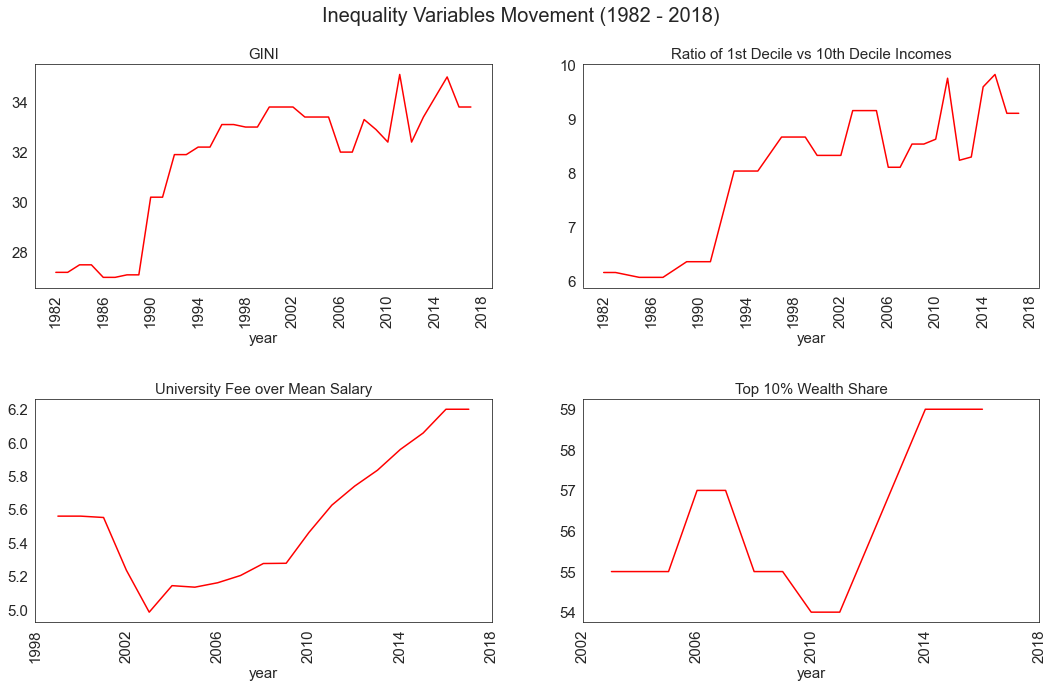

In [10]:
sns.set({'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 20, 'axes.titlesize': 15})
sns.set_style("white")
plt.rcParams['figure.figsize'] = [18,10]

fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plt.subplots_adjust(top=0.9)
plt.suptitle('Inequality Variables Movement (1982 - 2018)', fontsize = 20)

#Some variables have data in periods after 1982, so the xticks mark is adapted to that

ax = fig.add_subplot(2, 2, 1)
sns.lineplot(x=df['year'],y=df['GINI-BHC'],data = df,color="red")
ax.set(ylabel=None)
ax.set(title="GINI")
plt.xticks([1982,1986,1990,1994,1998,2002,2006,2010,2014,2018],rotation=90)


ax = fig.add_subplot(2, 2, 2)
g1=sns.lineplot(x=df['year'],y=df['D10:D1'],data = df,color="red")
ax.set(ylabel=None)
ax.set(title="Ratio of 1st Decile vs 10th Decile Incomes")
plt.xticks([1982,1986,1990,1994,1998,2002,2006,2010,2014,2018],rotation=90)


ax = fig.add_subplot(2, 2, 3)
sns.lineplot(x=df['year'],y=df['university_affordability_ratio_to_mean_salary'],data = df,color="red")
ax.set(ylabel=None)
ax.set(title="University Fee over Mean Salary")
plt.xticks([1998,2002,2006,2010,2014,2018],rotation=90)


ax = fig.add_subplot(2, 2, 4)
sns.lineplot(x=df['year'],y=df['top_10_perc_wealth_share'],data = df,color="red")
ax.set(ylabel=None)
ax.set(title="Top 10% Wealth Share")
plt.xticks([2002,2006,2010,2014,2018],rotation=90)


plt.show()

#### The four inequality indexes presented above show a clear increase in inequality rates overtime in New Zealand.

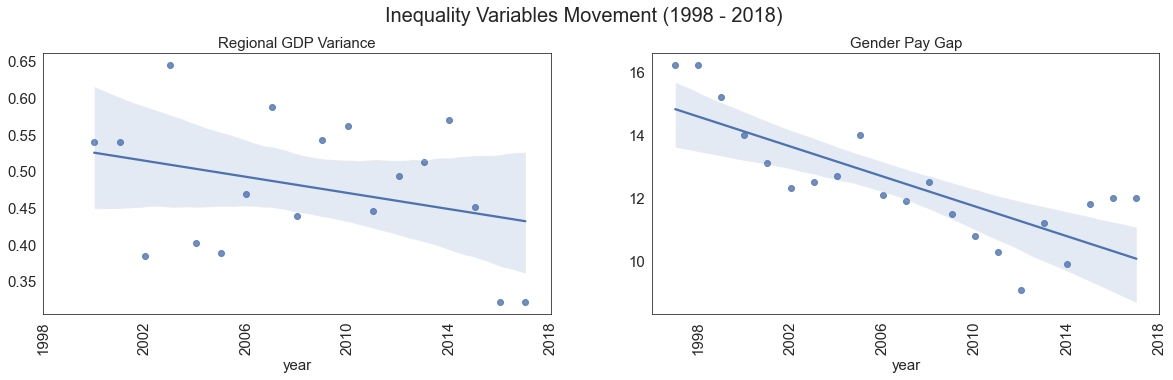

In [11]:
sns.set({'axes.labelsize': 15, 'font.size': 15, 'legend.fontsize': 20, 'axes.titlesize': 15})
sns.set_style("white")
plt.rcParams['figure.figsize'] = [20,5]

fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plt.subplots_adjust(top=0.85)
plt.suptitle('Inequality Variables Movement (1998 - 2018)', fontsize = 20)

#Some variables have data only after 2002, so the xticks mark is adapted to that

ax = fig.add_subplot(1, 2, 1)
sns.regplot(x=df['year'],y=df['regional_gdp_proportional_variation'],data = df,color="b")
ax.set(ylabel=None)
ax.set(title="Regional GDP Variance")
plt.xticks([1998,2002,2006,2010,2014,2018],rotation=90)

ax = fig.add_subplot(1, 2 , 2)
sns.regplot(x=df['year'],y=df['gender_pay_gap'],data = df,color="b")
ax.set(ylabel=None)
ax.set(title="Gender Pay Gap")
plt.xticks([1998,2002,2006,2010,2014,2018],rotation=90)

plt.show()

#### Regional GDP Variance and Gender Pay Gap showed a downwards trend, even though the slope isn't as significant as the increased inequality rates presented previously.

### 3.2 New Zealand vs International Inequality


According to the UN Report Inequality Measurement Development Issues No. 2 issued in 2015 (Ref 2), "GINI is the most widely cited measure of inequality; it measures the extent to which the distribution within an economy deviates from a perfectly equal distribution"

#### Considering GINI the most common inequality measurement, below the New Zealand's GINI coefficient is compared to other countries over the same period


In [12]:
#Rename dfglobal dataframe columns

dfglobal_=dfglobal[['Entity','Year','Gini index']]
dfglobal_.columns=['Country','Year','GINI']

#Create dfnz based on df, rename columns and add 'Country' column

dfnz=df[['year','GINI-BHC']]
dfnz.columns=['Year','GINI']
dfnz.insert(0,"Country","New Zealand")

#Concatenate both df to compare GINI index

dfcompare=pd.concat([dfglobal_,dfnz]).drop_duplicates().reset_index(drop=True)

In [13]:
#Create dataset just for the countries analysed next
countries1 = ['New Zealand','United Kingdom','Norway','Uruguay']

dfcompare_filter1 = dfcompare[dfcompare['Country'].isin(countries1)]
dfcompare_filter1= dfcompare_filter1.sort_values('GINI',ascending=False)

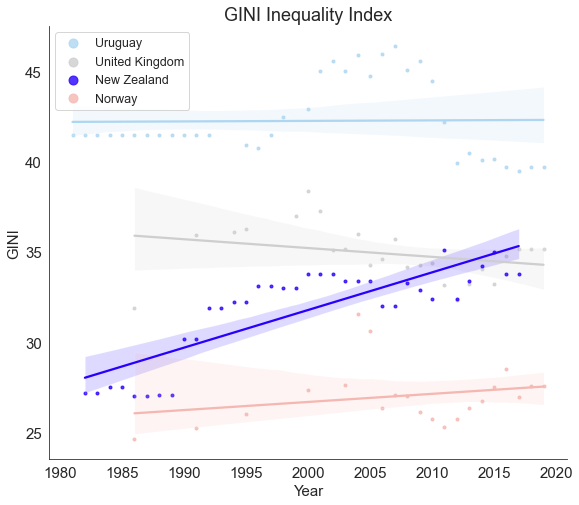

The slope of GINI overtime in New Zealand is:  0.2083
The slope of GINI overtime in the UK is:  -0.0488
The slope of GINI overtime in Uruguay is:  0.0029
The slope of GINI overtime in Norway is:  0.0448

New Zealand increased its inequality  4.64  times more than Norway over the analysed period.


In [14]:
#Create plot to analyse trend of inequality overtime
sns.set_style("white")

gf=sns.lmplot(
    data=dfcompare_filter1,
    x="Year", y="GINI", hue="Country",
    aspect=(1*1.2),
    height=7,
    scatter_kws={"s": 9},
    fit_reg=True,palette={'United Kingdom':"#cecece", 'Norway':"#F5B7B1", 'Uruguay':"#AED6F1", 'New Zealand':"#2700FF"}
    )

gf._legend.remove()
plt.legend(fontsize = 'small',markerscale=3)
plt.title("GINI Inequality Index",fontsize=18)

dfnz = dfcompare_filter1[dfcompare_filter1['Country'].isin({'New Zealand'})]
dfnz=dfnz.sort_values('Year',ascending=False)
dfnz=dfnz.dropna()
stnz=linregress(dfnz['Year'],dfnz['GINI'])

dfuk = dfcompare_filter1[dfcompare_filter1['Country'].isin({'United Kingdom'})]
dfuk=dfuk.sort_values('Year',ascending=False)
dfuk=dfuk.dropna()
stuk=linregress(dfuk['Year'],dfuk['GINI'])

dfuy = dfcompare_filter1[dfcompare_filter1['Country'].isin({'Uruguay'})]
dfuy=dfuy.sort_values('Year',ascending=False)
dfuy=dfuy.dropna()
stuy=linregress(dfuy['Year'],dfuy['GINI'])

dfnr = dfcompare_filter1[dfcompare_filter1['Country'].isin({'Norway'})]
dfnr=dfnr.sort_values('Year',ascending=False)
dfnr=dfnr.dropna()
stnr=linregress(dfnr['Year'],dfnr['GINI'])

ratio=stnz.slope/stnr.slope

plt.show()

print("The slope of GINI overtime in New Zealand is: ",round(stnz.slope,4)) 
print("The slope of GINI overtime in the UK is: ",round(stuk.slope,4))   
print("The slope of GINI overtime in Uruguay is: ",round(stuy.slope,4)) 
print("The slope of GINI overtime in Norway is: ",round(stnr.slope,4))
print("")
print("New Zealand increased its inequality ",round(ratio,2)," times more than Norway over the analysed period.")

#### Analysing the lineplot above and the calculated slope by country, it's possible to see that New Zealand presented the highest inequality increases of the selected countries.

#### Increases in inequality rates do not necessarily imply that a country has fallen behind other developed countries in terms of equality.<br><br>Below we select other countries and compare their GINI coefficient to the most recent New Zealand's index.

In [15]:
#Create dataframe just for the countries analysed next
countries2 = ['New Zealand','United Kingdom','Norway','Uruguay','Australia','Brazil','United States']

dfcompare_filter2 = dfcompare[dfcompare['Country'].isin(countries2)]
dfcompare_filter2= dfcompare_filter2.sort_values('GINI',ascending=False)
dfcompare_filter2 = dfcompare_filter2[dfcompare_filter2['Year'].isin({2017})]

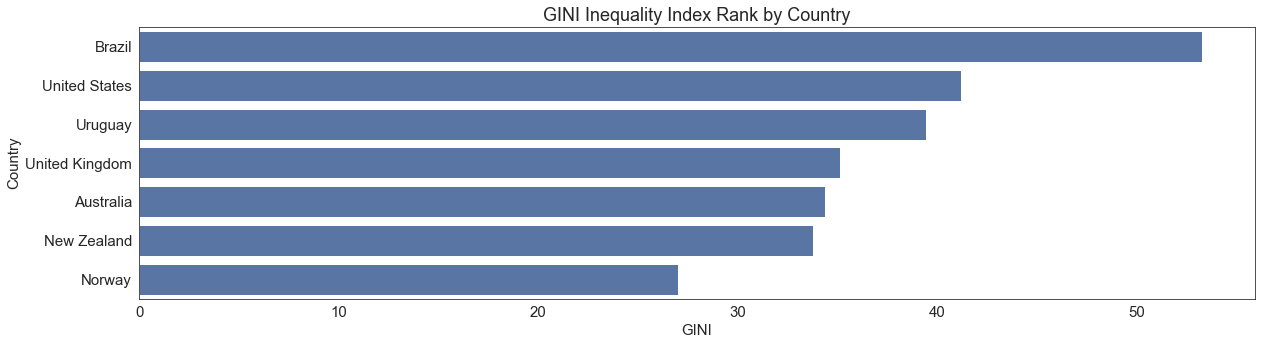

In [16]:
#Create plot ranking countries by GINI index descending
sns.barplot(x="GINI", y="Country", data=dfcompare_filter2,
            label="Total", color="b")

plt.title("GINI Inequality Index Rank by Country",fontsize=18)

plt.show()

#### Observing the chart above, New Zealand inequality rates are still below other developed countries like the UK, Australia and the US.

#### Knowing that NZ inequality rates are today in a relatively good position compared to other developed countries, but considering the rapid increase in its inequality rates, how is the country's GINI coefficient distribution over the analysed period, when compared to the global coefficient?

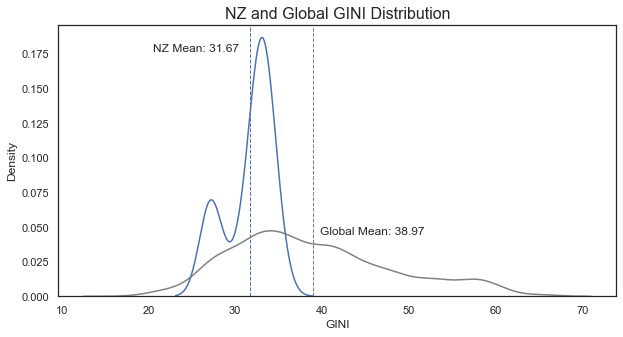

In [17]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("white")

sns.kdeplot(data=dfcompare, x="GINI",color="grey")
plt.axvline(dfcompare['GINI'].mean(), color='grey', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dfcompare['GINI'].mean()*1.02, max_ylim*0.9, 'Global Mean: {:.2f}'.format(dfcompare['GINI'].mean()))

dfnz = dfcompare[dfcompare['Country'].isin({'New Zealand'})]
sns.kdeplot(data=dfnz, x="GINI",color="b")
plt.axvline(dfnz['GINI'].mean(), color='b', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(dfnz['GINI'].mean()*0.65, max_ylim*0.9, 'NZ Mean: {:.2f}'.format(dfnz['GINI'].mean()))

plt.title('NZ and Global GINI Distribution', fontsize=16)
plt.show()

#### Even though the GINI coefficient in New Zealand increased, the distribution of the inequality measure and it's mean over the studied period is below the global values.

### 3.3 Inequality and Poverty

#### Inequality rates are just one side of the story about economics in a country.
As shown below, countries economically disadvantaged such as Bangladesh, will have low inequality rates, meaning poverty is spread accross the country. 

In cases like this, low inequality is not necessarily positive.

In [18]:
countries3 = ['New Zealand','Bangladesh']

dfcompare_filter3 = dfcompare[dfcompare['Country'].isin(countries3)]
dfcompare_filter3 = dfcompare_filter3.sort_values('GINI',ascending=False)

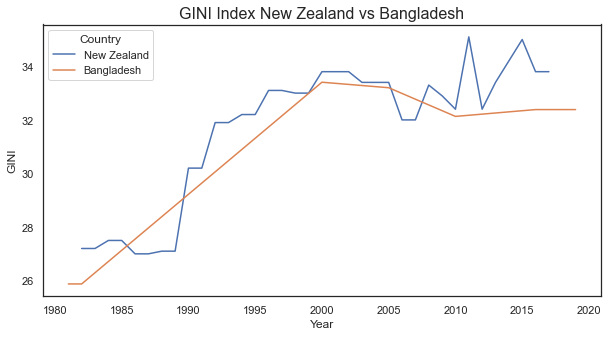

In [19]:
sns.set_style("white")

sns.lineplot(x=dfcompare_filter3['Year'], y=dfcompare_filter3['GINI'], hue=dfcompare_filter3['Country'], 
             data=pd.melt(dfcompare_filter3,['Year']))

plt.title("GINI Index New Zealand vs Bangladesh",fontsize=16)

plt.show()

#### As seen above, the GINI index in Bangladesh and New Zealand presented similar trend and value overtime. 
   Considering that Bangladesh is ranked 147th on GDP per capita ranking while New Zealand is the 32nd, the interpretation of inequality partially explains the economic scnenario of a country.
   
#### Below we compare poverty and inequality in New Zealand to verify if poverty and inequality are linked or if the increase in inequality is not correlated to poverty.  

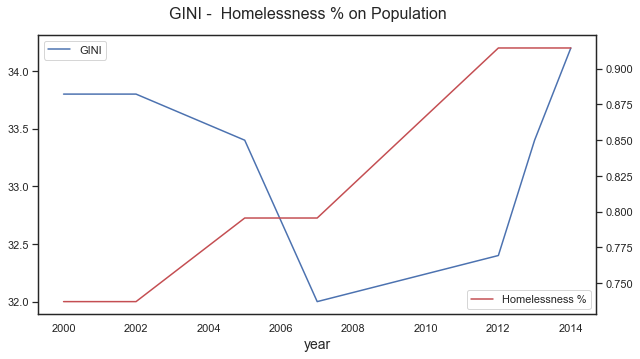

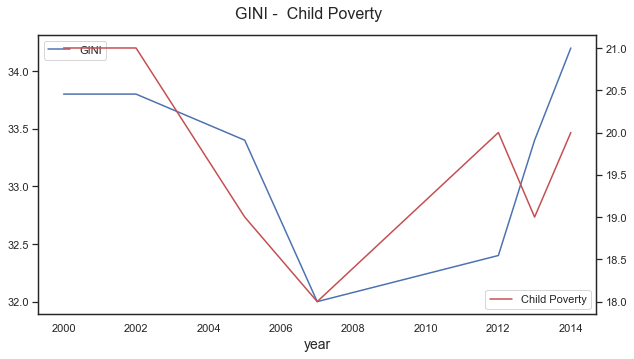

In [20]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

dfpov=df[['GINI-BHC','child_poverty_ahc_perc_HH_B50_contemp_median','year','homelessness_percentage_of_population']]
dfpov=dfpov.dropna()

plt.subplots_adjust(top=0.9)
plt.suptitle('GINI -  Homelessness % on Population', fontsize = 16)

fig.set_size_inches(10,5, forward=True)
# make a plot
ax.plot(dfpov['year'], dfpov['GINI-BHC'], "-b", label="GINI")
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dfpov['year'], dfpov['homelessness_percentage_of_population'], "-r", label="Homelessness %")

ax.legend(loc="upper left")
ax2.legend(loc="lower right")

# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.subplots_adjust(top=0.9)
plt.suptitle('GINI -  Child Poverty', fontsize = 16)

fig.set_size_inches(10,5, forward=True)
# make a plot
ax.plot(dfpov['year'], dfpov['GINI-BHC'], "-b", label="GINI")
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dfpov['year'], dfpov['child_poverty_ahc_perc_HH_B50_contemp_median'], "-r", label="Child Poverty")

ax.legend(loc="upper left")
ax2.legend(loc="lower right")
      
plt.show()
      
plt.show()

#### GINI -  Homelessness % on Population 
   Inequality in NZ decreased from 2000 to 2007 and only increased after that. Homelessness only increased through the whole period, even when inequality rates were falling in the 2000's.

#### GINI -  Child Poverty 
   The % of children in families earning below 50% of the median wage and GINI coefficient moved on the same direction overtime.

#### The two charts above show signs that inequality and poverty in New Zealand are positively correlated.

## 4. Correlation between Inequality Variables vs Socioeconomic Variables

### 4.1 Calculate Correlation over all variables for initial correlation assessment

In [21]:
#Create list to identify which pair of columns contain the most amount of combinations year on year.
    #Example: If Col1,Row2 = not null and Col3,Row2 = notnull, it's a match. 
#This will be used to evaluate if a correlation calculated later has enough pairs on the same year to consider it a solid correlation.

match_list=[]

for name,values in df.iloc[0].iteritems():
    for name2,values in df.iloc[0].iteritems():
        match=(name,name2,df[[name,name2]].notna().sum(axis=1))
        match_list.append(match)
        
dfmatch=pd.DataFrame(match_list,columns=['Variable1','Variable2','Match'])

dfmatch['MatchCount']=''
for i in range(0,10609):
    dfmatch['MatchCount'][i]=cl.Counter(dfmatch['Match'][i]).get(2)

In [22]:
#Run Correlation of all combination of variables (run this only once to discover good correlations)

correlation_list=[]

for name,values in df.iloc[0].iteritems():
    for name2,values in df.iloc[0].iteritems():
        correlation=(name,df[name].isna().sum(),name2,df[name2].isna().sum(),df[name].corr(df[name2]))
        correlation_list.append(correlation) 

#Create dataframe with list of all correlations

dfcorr=pd.DataFrame(correlation_list,columns=['Variable1','NAV1','Variable2','NAV2','Correlation'])

In [23]:
#Join Correlation dataframe and Matching Count dataframe to check which high correlations have high degrees of matching counts (avoid high correlation with low matching count)

dfcorrmatch=pd.merge(dfcorr,dfmatch,how="left",on=["Variable1","Variable2"])
dfcorrmatch=dfcorrmatch[['Variable1','Variable2','Correlation','MatchCount']]

dfcorrmatch=pd.merge(dfcorrmatch,
                     dfdoc[['Column name in dataset','Category']],
                     how="left",
                     left_on=["Variable1"],
                     right_on=["Column name in dataset"]
                    )
dfcorrmatch=pd.merge(dfcorrmatch,
                     dfdoc[['Column name in dataset','Category']],
                     how="left",
                     left_on=["Variable2"],
                     right_on=["Column name in dataset"]
                    )
dfcorrmatch=dfcorrmatch[['Variable1','Variable2','Correlation','MatchCount','Category_x','Category_y']]

dfcorrmatch['Correlation']= dfcorrmatch['Correlation'].apply(pd.to_numeric)
dfcorrmatch['MatchCount']= dfcorrmatch['MatchCount'].apply(pd.to_numeric)

In [24]:
#Assign level of correlation according to Akoglu H. criteria (Ref 3)

dfcorrmatch['corrstr']=''

for i in range(0,10608):
    if abs(dfcorrmatch['Correlation'][i])>=0.8:
        dfcorrmatch['corrstr'][i]='Very Strong'
    elif abs(dfcorrmatch['Correlation'][i])>=0.6 and dfcorrmatch['Correlation'][i]<0.8:
        dfcorrmatch['corrstr'][i]='Strong'
    elif abs(dfcorrmatch['Correlation'][i])>=0.4 and dfcorrmatch['Correlation'][i]<0.6:
        dfcorrmatch['corrstr'][i]='Moderate'
    elif abs(dfcorrmatch['Correlation'][i])>=0.2 and dfcorrmatch['Correlation'][i]<0.4:
        dfcorrmatch['corrstr'][i]='Weak'
    elif abs(dfcorrmatch['Correlation'][i])>=0.0 and dfcorrmatch['Correlation'][i]<0.2:
        dfcorrmatch['corrstr'][i]='Very Weak'
        
for i in range (0,10608):
    if dfcorrmatch['Variable1'][i]=='year':
        dfcorrmatch['Category_x'][i]='Year'
        
for i in range (0,10608):
    if dfcorrmatch['Variable2'][i]=='year':
        dfcorrmatch['Category_y'][i]='Year'

In [25]:
#Analyse Correlation between Inequality variables and all the other variables in the dataset

ineqvar=['GINI-BHC','regional_gdp_proportional_variation','university_affordability_ratio_to_mean_salary','top_10_perc_wealth_share','gender_pay_gap']
corrstr=['Very Strong','Strong','Moderate']
dfcorrineq=dfcorrmatch[dfcorrmatch['Variable1'].isin(ineqvar)&dfcorrmatch['corrstr'].isin(corrstr)]

#Sample of dataframe below
dfcorrineq.head(3)

,Variable1,Variable2,Correlation,MatchCount,Category_x,Category_y,corrstr
721,GINI-BHC,Q5:Q1,0.970455,32,Income and wealth,Income and wealth,Very Strong
722,GINI-BHC,D10:D1,0.945847,32,Income and wealth,Income and wealth,Very Strong
723,GINI-BHC,D10:D1-4(Palma),0.972769,32,Income and wealth,Income and wealth,Very Strong


#### The dataset above was extracted and an analysis on correlation pairs was made to proceed to the next steps

### 4.2 Visual and Statistical Analysis of Variables of Interest

#### 4.2.1 Gender Pay Gap vs Suicide Rates

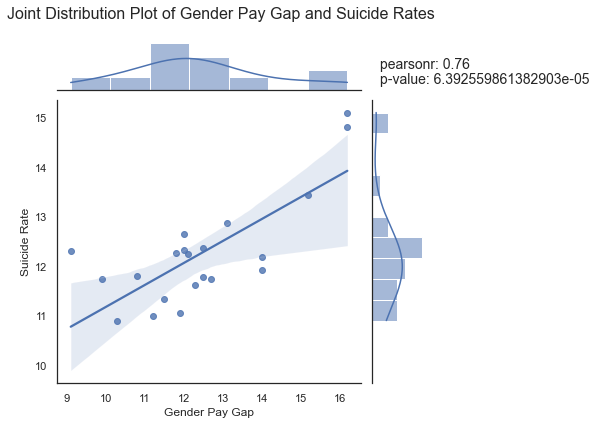

In [26]:
a='gender_pay_gap'
b='suicides_per_100000'
dfreg=df[[a,b]]
dfreg=dfreg.dropna()
dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])

g1=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
g1.ax_joint.set_xlabel('Gender Pay Gap')
g1.ax_joint.set_ylabel('Suicide Rate')
plt.text(1,16,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,15.7,"p-value: "+str(dfstats[1]),fontsize=14)


plt.subplots_adjust(top=0.9)
plt.suptitle("Joint Distribution Plot of Gender Pay Gap and Suicide Rates",fontsize=16)
plt.show()

##### The correlation between Gender Pay Gap and Suicide Rates were already analysed in the studies below:
* Columbia University, Unequal depression for equal work? How the wage gap explains gendered disparities in mood disorders (Ref 4)
* Gender inequality and adolescent suicide ideation across Africa, Asia, the South Pacific and Latin America – a cross-sectional study based on the Global School Health Survey (Ref 5)

##### Both studies identified that there is a correlation between gender pay gap and suicide rates.

When compared with a more equal society, the gender inequality index was associated with a higher risk of suicide ideation for both girls and boys.<br>
The studies mentioned above explain this correlation with the increasing anxiety and stress in more unequal societies, but this analysis don't confirm any causation relationship between the variables.

In New Zealand, the correlation between Suicide Rates and the Gender Pay Gap is also existent.
The pearson correlation is strong (0.685) and the p-value<0.05, so it's possible to confirm that the correlation is true.

#### 4.2.2 University Affordability vs Adult Depression/ Anxiety

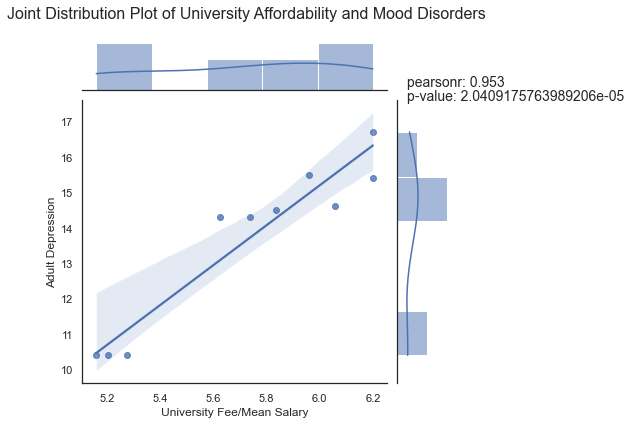

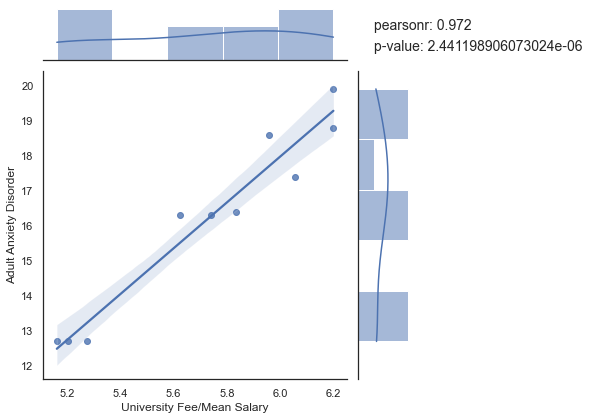

In [27]:
a='university_affordability_ratio_to_mean_salary'
b='depression_adult'
c='mood_anxiety_disorder_adult'

dfreg1=df[[a,b]]
dfreg1=dfreg1.dropna()

dfreg2=df[[a,c]]
dfreg2=dfreg2.dropna()

dfstats=scipy.stats.pearsonr(dfreg1[a], dfreg1[b])

g2=sns.jointplot(data=dfreg1,x=a,y=b,kind="reg")
g2.ax_joint.set_xlabel('University Fee/Mean Salary')
g2.ax_joint.set_ylabel('Adult Depression')

plt.suptitle("Joint Distribution Plot of University Affordability and Mood Disorders",fontsize=16)
plt.subplots_adjust(top=0.9)

plt.text(1,18,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,17.6,"p-value: "+str(dfstats[1]),fontsize=14)

dfstats=scipy.stats.pearsonr(dfreg2[a], dfreg2[c])

g3=sns.jointplot(data=dfreg2,x=a,y=c,kind="reg")
g3.ax_joint.set_xlabel('University Fee/Mean Salary')
g3.ax_joint.set_ylabel('Adult Anxiety Disorder')

plt.text(1,21.6,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,21,"p-value: "+str(dfstats[1]),fontsize=14)

plt.show()

##### The relationship between Adult Depression and Anxiety Disorder when correlated to University Affordability is very strong, even though there are not many points of reference in the dataset.
   As presented in the article "Tuition fees have led to surge in students seeking counselling" (Ref 6) published at The Guardian, the increase in tuition fees, therefore the decrease in education affordability is linked to increase in psychological distress issues.

#### 4.2.3 University Affordability vs Adult Healthy Weight

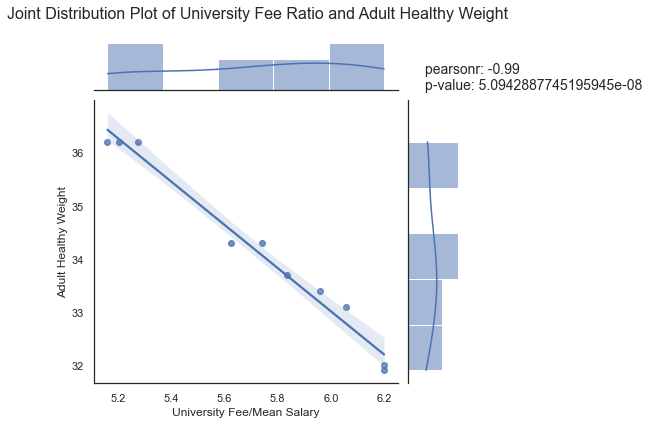

In [31]:
a='university_affordability_ratio_to_mean_salary'
b='healthy_weight_adult'

dfreg=df[[a,b]]
dfreg=dfreg.dropna()

dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])

g4=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
g4.ax_joint.set_xlabel('University Fee/Mean Salary')
g4.ax_joint.set_ylabel('Adult Healthy Weight')

plt.text(1,37.5,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,37.2,"p-value: "+str(dfstats[1]),fontsize=14)

plt.subplots_adjust(top=0.9)
plt.suptitle("Joint Distribution Plot of University Fee Ratio and Adult Healthy Weight",fontsize=16)
plt.show()

##### A strong correlation between University Affordability and the percentage of adults with a healthy weight can be observed in the dataset
   The relationship between obesity and education was assessed by the OECD in the study "Exploring the Relationship Between Education and Obesity". (Ref 7)<br>According to the study there is a "broadly linear relationship between the number of years spent in full-time education and the probability of obesity, with most educated individuals displaying lower rates of the condition"
   
   Considering that the increasing university fee/mean salary ratio in New Zealand is linked to the decrease in adult healthy weight, it's possible to link the findings in the OECD study to the correlations found in this analysis.

#### 4.2.4 Inequality Impact on Education Measures - Risk of Inequality Cycle

##### University Affordability vs Tertiary Education Participation

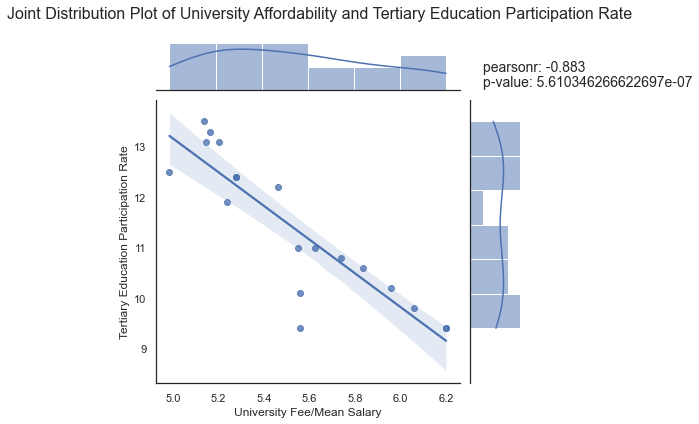

In [29]:
a='university_affordability_ratio_to_mean_salary'
b='teriary_education_participation_rate'

dfreg=df[[a,b]]
dfreg=dfreg.dropna()

dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])

g4=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
g4.ax_joint.set_xlabel('University Fee/Mean Salary')
g4.ax_joint.set_ylabel('Tertiary Education Participation Rate')

plt.text(1,14.5,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,14.2,"p-value: "+str(dfstats[1]),fontsize=14)

plt.subplots_adjust(top=0.9)
plt.suptitle("Joint Distribution Plot of University Affordability and Tertiary Education Participation Rate",fontsize=16)
plt.show()

##### There is a strong correlation between the university affordability over mean salaries when related to the participation rates on tertiary education. 
Obviously, the increase in university fee/mean salary ratio is related to the decrease in tertiary education participation.

##### University Affordability vs Bachelors Earning Premium (Inequality Generating Inequality Risk)

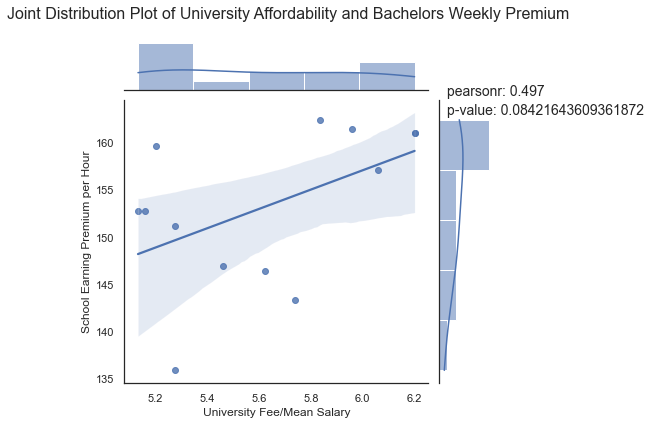

In [30]:
a='university_affordability_ratio_to_mean_salary'
b='bachelors_earning_premium_weekly'

dfreg=df[[a,b]]
dfreg=dfreg.dropna()

dfstats=scipy.stats.pearsonr(dfreg[a], dfreg[b])

g4=sns.jointplot(data=dfreg,x=a,y=b,kind="reg")
g4.ax_joint.set_xlabel('University Fee/Mean Salary')
g4.ax_joint.set_ylabel('School Earning Premium per Hour')

plt.text(1,165,"pearsonr: "+str(round(dfstats[0],3)),fontsize=14)
plt.text(1,163,"p-value: "+str(dfstats[1]),fontsize=14)

plt.subplots_adjust(top=0.9)
plt.suptitle("Joint Distribution Plot of University Affordability and Bachelors Weekly Premium",fontsize=16)
plt.show()

##### The correlation between university affordability and the premium earnings for a bachelor's degree is moderate.<br> Although, the correlation can't be considered for further causation analysis as the p-value on this study is >0.05, therefore it is not statistically significant and does indicates strong evidence for the null hypothesis.

##### No clear indication that low affordability for university education is linked to increasing premium wages after a bachelor's degree is a positive sign, as the inequality cycle is not exponentially increasing being impacted by itself.<br>If a society presents positive correlation between Education Premium and Inequality, the economic gap between people those at the top/bottom of the financial spectrum will rapidily increase

## 5. Conclusion

##### After analysing the New Zealand data








- What is the trend of inequality indexes in New Zealand over the analysed period?
- How is NZ inequality variance over the analysed period is compared to other countries?
- How was the different levels of the GINI coefficient distributed overtime (GINI density)?
- Is poverty and inequality the same in macroeconomic measures? (developed countries are equal while low-income countries are unequal)
- In New Zealand, inequality and poverty move in the same direction overtime?
- What is the correlation between Inequality vs Health and Education values in New Zealand?

## 6. References

* Ref 1 | Our World in Data: https://ourworldindata.org/grapher/economic-inequality-gini-index?tab=table&time=1982..2018
* Ref 2 | UN Report Inequality Measurement Development Issues No. 2: https://www.un.org/en/development/desa/policy/wess/wess_dev_issues/dsp_policy_02.pdf
* Ref 3 | User's guide to correlation coefficients. Akoglu H. Turk J Emerg Med. 2018 https://pubmed.ncbi.nlm.nih.gov/30191186/
* Ref 4 | Unequal depression for equal work? How the wage gap explains gendered disparities in mood disorders https://pubmed.ncbi.nlm.nih.gov/26689629/
* Ref 5 | Gender inequality and adolescent suicide ideation across Africa, Asia, the South Pacific and Latin America https://pubmed.ncbi.nlm.nih.gov/31544685/
* Ref 6 | Tuition fees have led to surge in students seeking counselling, The Guardian https://www.theguardian.com/education/2016/mar/13/tuition-fees-have-led-to-surge-in-students-seeking-counselling
* Ref 7 | https://www.oecd.org/economy/growth/relationship%20education%20and%20obesity.pdf